In [1]:
# pip install pyodbc

Import specialized packages

In [2]:
import numpy as np
import pandas as pd
import pyodbc
import itertools
import seaborn as sns
import matplotlib.pyplot as plt


Set global settings for better look and feel

In [30]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = 30
#plt.style.use("seaborn-whitegrid")
sns.set_color_codes("muted")

Connect Python with SQL Server using pyodbc

In [3]:
SERVER = "."
DATABASE = "RFM_Data" 
connectionString = f'DRIVER={{ODBC Driver 13 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;'
conn = pyodbc.connect(connectionString)

Get data from database and compute Recency, Frequency, Monetary

In [4]:
cursor = conn.cursor()
query = "select T.CustomerID, datediff(day, max(T.Purchase_Date), '2022-09-01') as Recency,\
		cast(count(T.Purchase_Date)/(1.00*Datediff(day, R.created_date, '2022-09-01')/365) as decimal(8,2)) as Frequency,\
		cast(sum(T.GMV)/(1.00*Datediff(day, R.created_date, '2022-09-01')/365) as decimal(8,2)) as Monetary\
		into #temp_table\
		from Customer_Transaction T join Customer_Registered R on T.CustomerID = R.ID\
		group by T.CustomerID, R.created_date"
cursor.execute(query)
df = pd.read_sql_query("select * from #temp_table",conn)
cursor.close()
conn.close()
df.head(10)

C:\Users\hungl\AppData\Local\Temp\ipykernel_18980\4294511275.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from #temp_table",conn)


,CustomerID,Recency,Frequency,Monetary
0,895524,92,0.25,21352.38
1,838054,62,0.24,20697.13
2,853482,31,0.25,23318.77
3,720768,62,0.23,33161.03
4,620634,31,0.22,16159.98
5,781753,62,0.24,17741.41
6,849219,31,0.49,36720.33
7,995700,92,0.27,25310.22
8,698207,62,0.23,6771.80
9,619154,62,0.22,16150.44


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114081 entries, 0 to 114080
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  114081 non-null  int64  
 1   Recency     114081 non-null  int64  
 2   Frequency   114081 non-null  float64
 3   Monetary    114081 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 3.5 MB


Compute F, M indicators based on Quartiles

In [6]:
def compute_FM(x):      
    if x < Q1:
        return 1
    elif (x >= Q1 and x < Q2):
        return 2
    elif (x >= Q2 and x < Q3):
        return 3
    else:
        return 4

Compute R indicators based on Quartiles

In [7]:
def compute_R(x):      
    if x < Q1:
        return 4
    elif (x >= Q1 and x < Q2):
        return 3
    elif (x >= Q2 and x < Q3):
        return 2
    else:
        return 1

In [8]:
Q1 = df["Recency"].quantile(0.25)
Q2 = df["Recency"].quantile(0.5)
Q3 = df["Recency"].quantile(0.75)
list_R = [Q1,Q2,Q3]
df["R"] = df["Recency"].apply(compute_R)

In [9]:
Q1 = df["Frequency"].quantile(0.25)
Q2 = df["Frequency"].quantile(0.5)
Q3 = df["Frequency"].quantile(0.75)
list_F = [Q1,Q2,Q3]
df["F"] = df["Frequency"].apply(compute_FM)

In [10]:
Q1 = df["Monetary"].quantile(0.25)
Q2 = df["Monetary"].quantile(0.5)
Q3 = df["Monetary"].quantile(0.75)
list_M = [Q1,Q2,Q3]
df["M"] = df["Monetary"].apply(compute_FM)

Generate a dataframe about Quartiles of R, F, M

In [11]:
Quartiles =["Q1","Q2","Q3"]
df_quartiles = pd.DataFrame(list(zip(Quartiles, list_R,list_F,list_M)), columns=["Quartiles","R","F","M"])
df_quartiles

,Quartiles,R,F,M
0,Q1,31.0,0.19,15625.00
1,Q2,62.0,0.23,19174.91
2,Q3,92.0,0.26,23831.62


Add RFM column  by joining R, F, M columns

In [12]:
df["RFM"] = df[["R","F","M"]].apply(lambda x: "".join(x.values.astype(str)), axis= 1)


Generate Segment column by defining segment function and applying it

In [16]:
def segment(i):
    R = int(i[0]) 
    F = int(i[1])
    M = int(i[2])
    if R>=3 and F>=3 and M >=3:
        return "VIP"
    elif (R<=2 or F<=2) and M>=3:
        return "Potential Customers"
    elif (R>=3 or F>=3) and M<=2:
        return "Loyal Customers"
    else:
        return "Walk-in customers"


In [17]:
df["Segment"] = df["RFM"].apply(segment)

Identify which segment each RFM belongs to

In [26]:
len(df["RFM"].unique()) # There are 63 RFM's triplets in our data set

63

In [27]:
# Generate a list which includes all possible RFM's triplets
values = list(range(1, 5))
product  = itertools.product(values, repeat = 3)
result = [str(a)+str(b)+str(c) for a, b, c in product]
list_classify = [(i, segment(i)) for i in result]
dict_classify = {"VIP":[], "Potential Customers":[],"Loyal Customers":[],"Walk-in customers":[]}
for i, segment_i in list_classify:
    dict_classify[segment_i].append(i)
No_of_RFM = [len(dict_classify["VIP"]), len(dict_classify["Potential Customers"]), len(dict_classify["Loyal Customers"]),len(dict_classify["Walk-in customers"])]
df_segment = pd.DataFrame(list(zip(list(dict_classify.keys()), list(dict_classify.values()), No_of_RFM)), columns=["segment","RFM","No.of RFM"])
df_segment

,segment,RFM,No.of RFM
0,VIP,"[333, 334, 343, 344, 433, 434, 443, 444]",8
1,Potential Customers,"[113, 114, 123, 124, 133, 134, 143, 144, 213, ...",24
2,Loyal Customers,"[131, 132, 141, 142, 231, 232, 241, 242, 311, ...",24
3,Walk-in customers,"[111, 112, 121, 122, 211, 212, 221, 222]",8


Plot the Pie chart about Percentage of Segment

Text(0, 0.5, '')

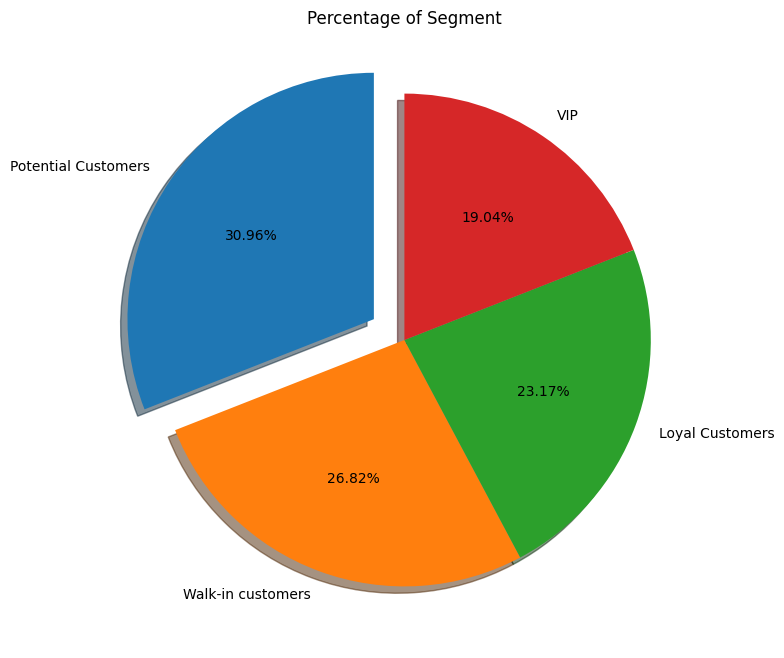

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
Percentage_of_Segment =  df["Segment"].value_counts().plot(kind= "pie", title="Percentage of Segment", autopct='%.2f%%', startangle= 90, explode= [0.15,0,0,0], shadow=True)
Percentage_of_Segment.set_ylabel(None)

Plot the bar chart about Top 10 highest RFM

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '344'),
  Text(1, 0, '111'),
  Text(2, 0, '311'),
  Text(3, 0, '211'),
  Text(4, 0, '122'),
  Text(5, 0, '133'),
  Text(6, 0, '132'),
  Text(7, 0, '143'),
  Text(8, 0, '121'),
  Text(9, 0, '322')])

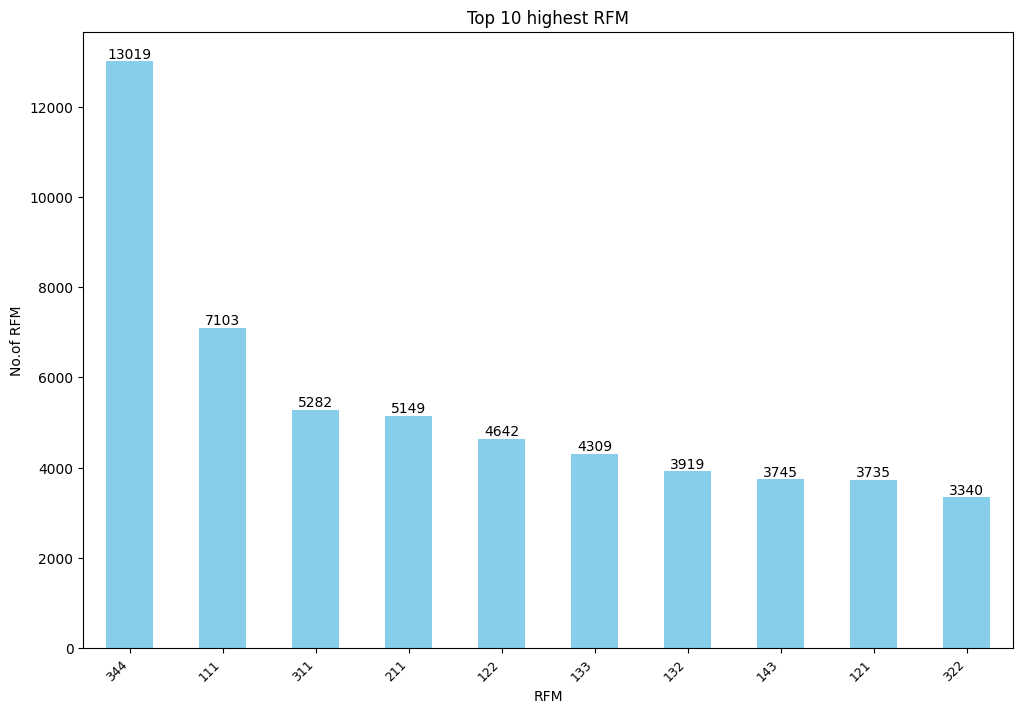

In [22]:
RFM_top10 = df["RFM"].value_counts().nlargest(10)
fig, ax = plt.subplots(figsize = (12,8))
RFM_top10_chart = RFM_top10.plot(kind= "bar", color = "skyblue")
for i in RFM_top10_chart.containers:
    RFM_top10_chart.bar_label(i,fmt = "%.0f",label_type="edge")
plt.title("Top 10 highest RFM")
plt.ylabel('No.of RFM')
plt.xticks(rotation=45, ha='right', fontsize=9)

Compute Indicators for each Segment

In [29]:
df_RFM_result= df.groupby("Segment").agg({"Monetary":'sum', "R": 'mean', 'F': 'mean'}).reset_index()
df_RFM_result.columns = ["Segment", "Monetary_sum", "R_Average", "F_Average"]
df_RFM_result.sort_values(by="Monetary_sum", ascending=False).round(3)

,Segment,Monetary_sum,R_Average,F_Average
1,Potential Customers,8.354321e+08,1.573,2.982
2,VIP,6.905198e+08,3.008,3.751
3,Walk-in customers,4.494258e+08,1.424,1.476
0,Loyal Customers,4.181488e+08,2.482,2.328


In [24]:
# df.to_csv("RFM_data.csv",index=False)